In [1]:
import numpy as np
import random
import math
import heapq
import ray
from benchmark_parser import all_parser, parser
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from gym.spaces import Discrete, MultiDiscrete, Dict
from ray import tune, air
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.agents.ppo import PPOTrainer
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ray.tune.registry import register_env
from ray.rllib.utils.pre_checks.env import check_env
from my_env import RtGridEnv, MultiEnv, SwitchBenchmarkCallback, PrintEnvCallback
from ray.rllib.algorithms.callbacks import DefaultCallbacks

In [4]:
env_config = all_parser("/home/brucexi2/UBC-EECE-597_multi-agent-RL-IC-routing/benchmarks")
register_env("multi_env", lambda config:MultiEnv({"benchmarks": env_config}))
env = MultiEnv({"benchmarks": env_config})
check_env(env)
config = (
    PPOConfig()
    .environment(env = "multi_env")
    .rollouts(num_rollout_workers=2)
    #.evaluation(evaluation_interval=15, evaluation_duration=5, evaluation_num_workers=1)
    #.training(gamma=tune.grid_search([0.99, 1]))
)

2023-08-27 18:56:29,696	WARNING env.py:247 -- Your MultiAgentEnv <MultiEnv instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.


In [2]:
# Algo with callbacks to switch env during training
env_config = all_parser("/home/brucexi2/UBC-EECE-597_multi-agent-RL-IC-routing/benchmarks")
def env_creator(env_config):
    return MultiEnv(env_config)
register_env("multi_env", env_creator)

algo = PPOTrainer(
    env="multi_env", 
    config={"env_config": {"benchmarks": env_config}, "callbacks": SwitchBenchmarkCallback})

2023-08-27 19:10:38,812	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='multi_env', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('multi_env').build()` instead. This will raise an error in the future!
2023-08-27 19:10:40,595	INFO worker.py:1538 -- Started a local Ray instance.
(raylet) /home/brucexi2/anaconda3/lib/python3.10/site-packages/ray/dashboard/agent.py:51: DeprecationWarning: There is no current event loop
(raylet)   aiogrpc.init_grpc_aio()
(RolloutWorker pid=409482) 2023-08-27 19:10:44,783	WARNING env.py:247 -- Your MultiAgentEnv <MultiEnv instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.
2023-08-27 19:10:45,899	WARNING util.py:66 -- Install gputil for GPU system monitoring.


In [15]:
# Normal algo without callbacks
env_config = all_parser("/home/brucexi2/UBC-EECE-597_multi-agent-RL-IC-routing/benchmarks")
def env_creator(env_config):
    return MultiEnv(env_config)
register_env("multi_env", env_creator)

algo = PPOTrainer(
    env="multi_env", 
    config={"env_config": {"benchmarks": env_config}})

2023-08-28 09:15:53,217	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='multi_env', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('multi_env').build()` instead. This will raise an error in the future!
(RolloutWorker pid=512436) 2023-08-28 09:15:56,586	WARNING env.py:247 -- Your MultiAgentEnv <MultiEnv instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.
2023-08-28 09:15:57,549	WARNING util.py:66 -- Install gputil for GPU system monitoring.


In [7]:
# Train the algo
rewards = []
checkpoint_dir = "/home/brucexi2/UBC-EECE-597_multi-agent-RL-IC-routing/MA_runs/multi_env"
for i in range(2000):
    result = algo.train()
    rewards.append(result["episode_reward_mean"])
    if i%100 == 0:
        checkpoint_file = algo.save(checkpoint_dir)
print(rewards)

(RolloutWorker pid=409482) [[(18, 7), (1, 1)], [(1, 2), (18, 8)]]
(RolloutWorker pid=409482) [[(1, 1), (5, 1), (3, 8)], [(9, 1), (14, 8), (9, 8)], [(18, 8), (11, 1)]]
(RolloutWorker pid=409482) [[(1, 1), (5, 1), (3, 8)], [(9, 1), (14, 8), (9, 8)], [(18, 8), (11, 1)]]
(RolloutWorker pid=409482) [[(0, 1), (5, 2), (7, 1)], [(1, 1), (6, 1)], [(2, 1), (5, 1)], [(0, 0), (7, 0)]]
(RolloutWorker pid=409482) [[(0, 1), (5, 2), (7, 1)], [(1, 1), (6, 1)], [(2, 1), (5, 1)], [(0, 0), (7, 0)]]
(RolloutWorker pid=409482) [[(1, 1), (1, 8), (18, 8)], [(10, 1), (10, 8)], [(6, 1), (6, 8), (15, 8)]]
(RolloutWorker pid=409482) [[(1, 1), (1, 8), (18, 8)], [(10, 1), (10, 8)], [(6, 1), (6, 8), (15, 8)]]
(RolloutWorker pid=409482) [[(3, 5), (24, 2), (24, 11)], [(24, 4), (24, 9), (5, 5)], [(4, 2), (29, 3)], [(29, 10), (34, 8)]]
(RolloutWorker pid=409484) [[(46, 5), (74, 5), (46, 11), (68, 11)], [(71, 31), (72, 27), (66, 38)], [(63, 31), (78, 27)], [(35, 38), (29, 21), (14, 2), (24, 27), (9, 14)], [(77, 5), (61, 

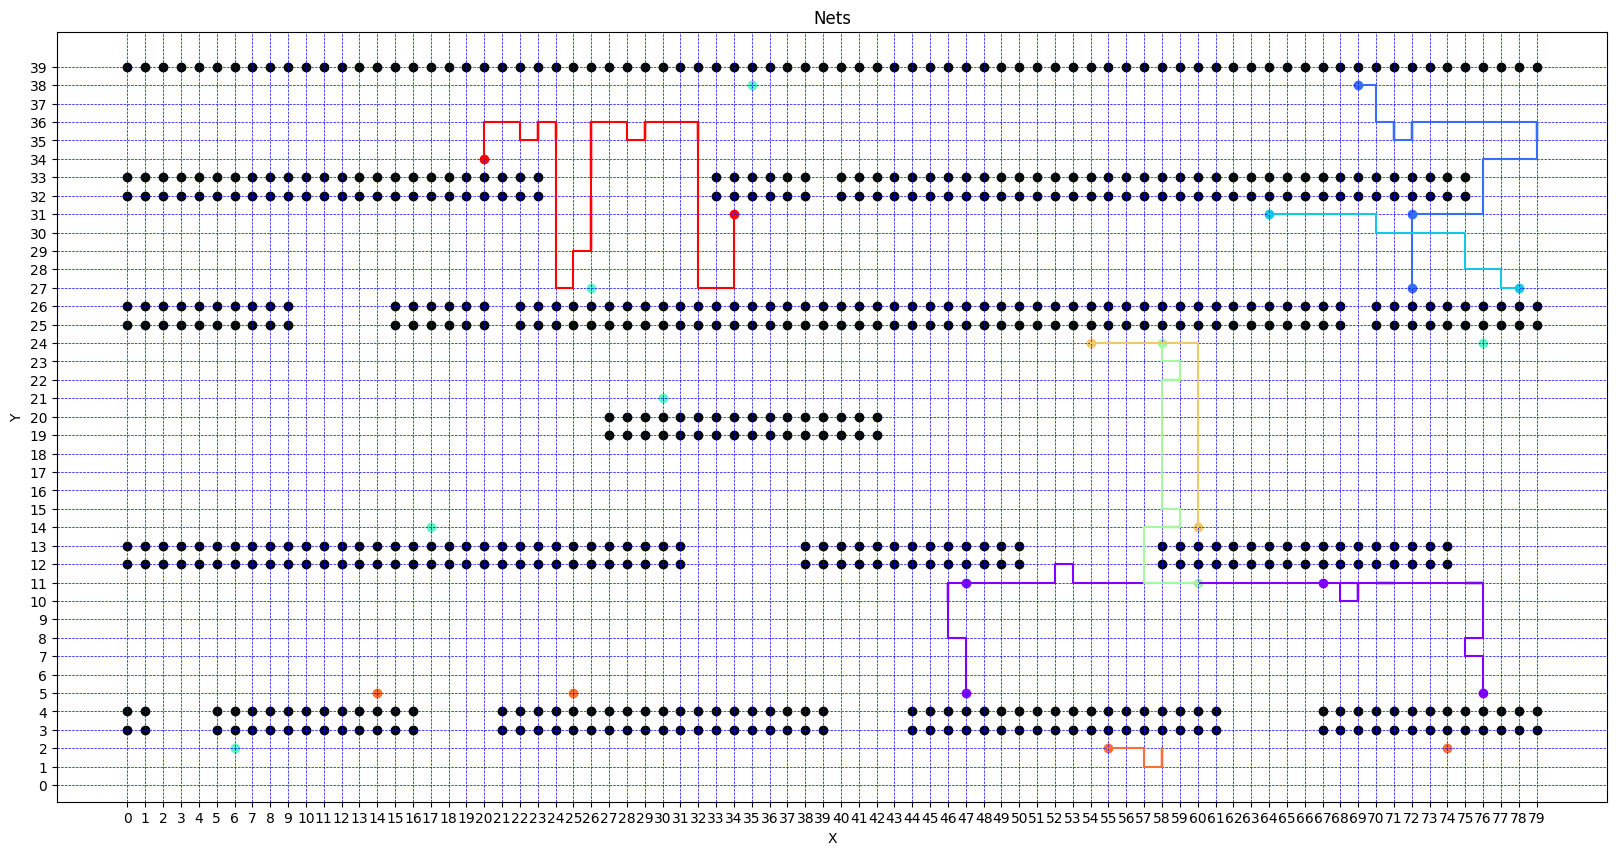

-2202


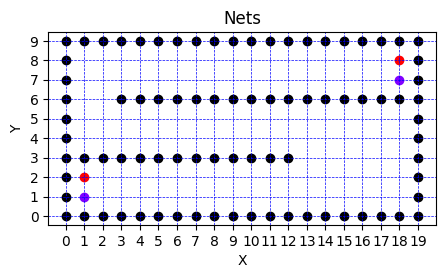

-2000


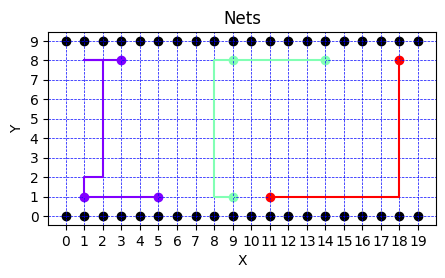

12


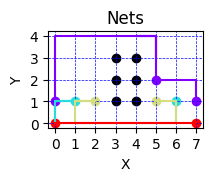

9


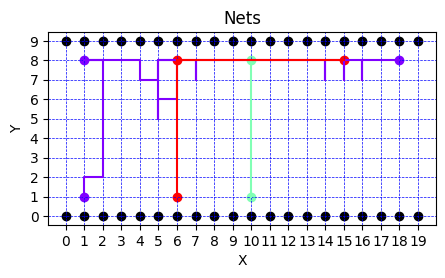

-12


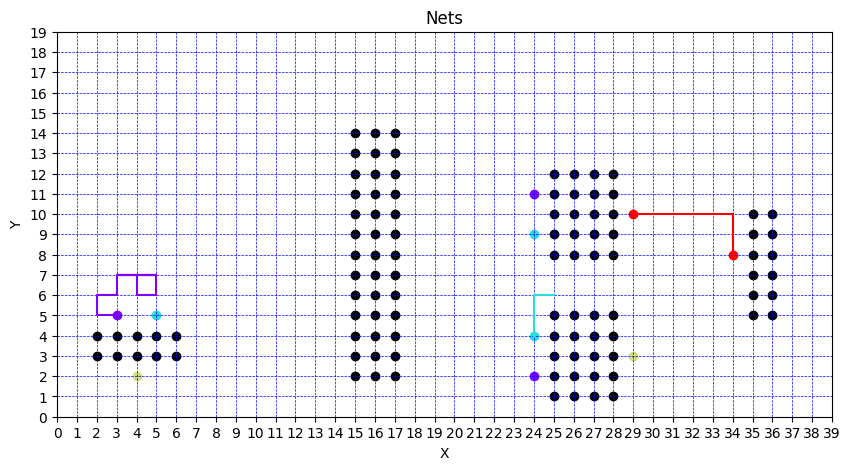

-2996


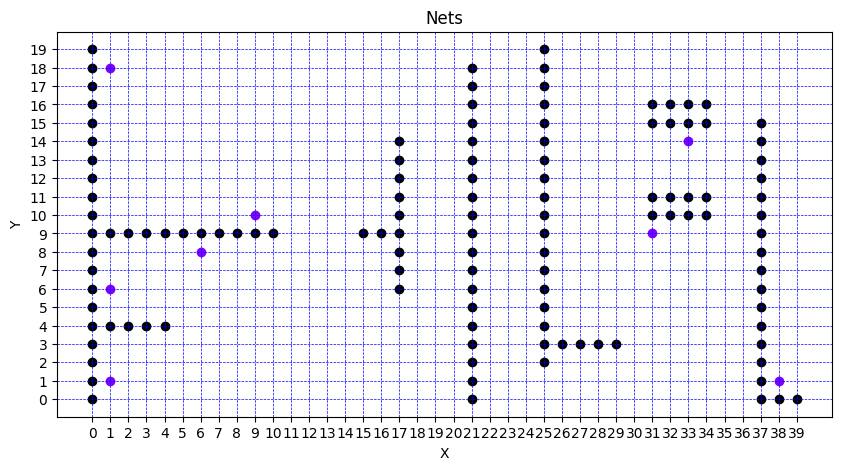

-1000


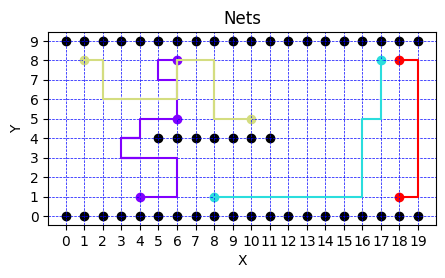

-15


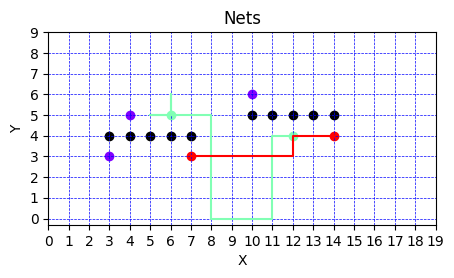

-1005


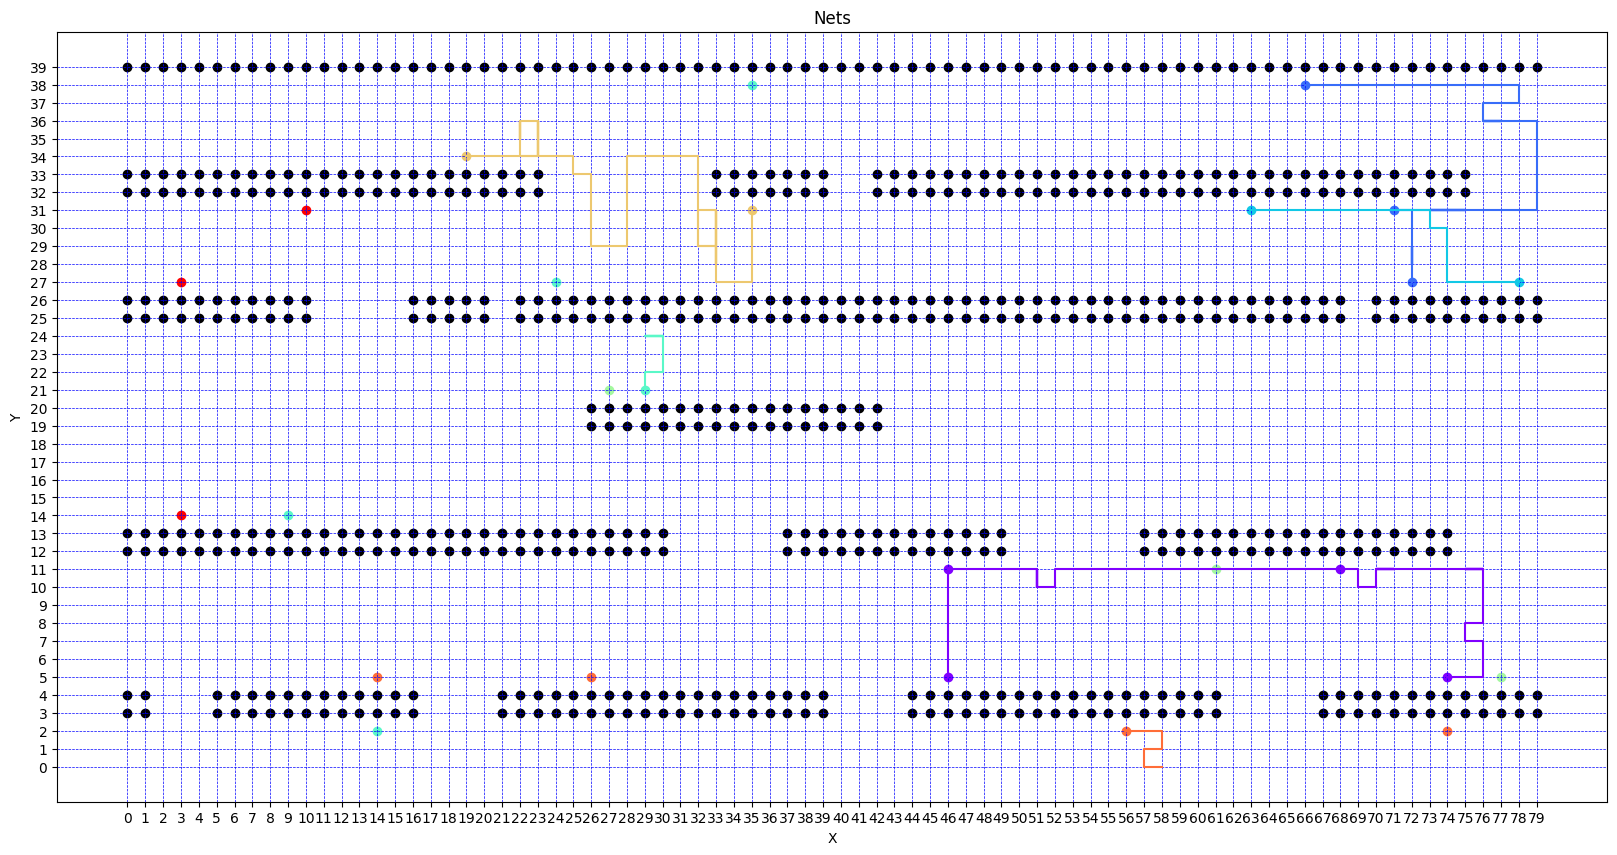

-4156


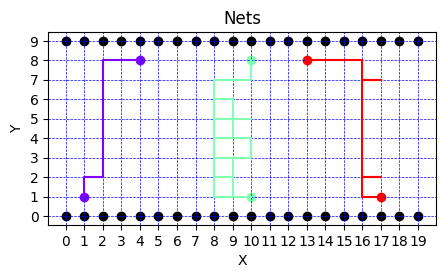

-27


In [17]:
# Run inference on the trained algo
env = MultiEnv({"benchmarks": env_config})
num_env = len(env.envs)
for j in range(num_env):
    env.switch_benchmark(j)
    n_nets = len(env.current_env.agents_id)
    total_reward = 0
    obs = env.reset()
    done = {}
    for i in range(n_nets):
        done["agent_{}".format(i)] = False
    done["__all__"] = False
    while True:
        action = algo.compute_actions(observations=obs, explore=False)
        # only agents that are not done will be provided an action
        action = {agent: action[agent] for agent in done if not done[agent] and agent != "__all__"}
        obs, reward, done, info = env.step(action)
        total_reward += sum(reward.values())
        if done["__all__"]:
            break
    env.current_env.render()
    #env.current_env.heatmap()
    print(total_reward)

In [11]:
# Try the pre-trained zero-shot policy on a super simple benchmark
env_config = [{'length': 3, 'width': 3, 'nets': [[(0,0), (2,2)]], 'macros': [], 'edge_capacity': np.full((3, 3, 4), 3)}]
env = MultiEnv({"benchmarks": env_config})

In [10]:
import os
directory_path = "/home/brucexi2/UBC-EECE-597_multi-agent-RL-IC-routing/benchmarks"
benchmarks = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
print(benchmarks)

['temp.infile', 'oswald.infile', 'stanley.infile', 'congestion.infile', 'impossible.infile', 'kuma.infile', 'wavy.infile', 'misty.infile', 'rusty.infile', 'stdcell.infile', 'sydney.infile']


In [16]:
algo.stop()